# Анализ и парсинг

Импорты


In [1]:
! pip install dotenv

  Using cached dotenv-0.9.9-py2.py3-none-any.whl.metadata (279 bytes)
  Using cached python_dotenv-1.1.0-py3-none-any.whl.metadata (24 kB)
Using cached dotenv-0.9.9-py2.py3-none-any.whl (1.9 kB)
Using cached python_dotenv-1.1.0-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [dotenv]


In [3]:
import os
import networkx as nx
import plotly.graph_objects as go
import pandas as pd
from langchain_openai.chat_models import ChatOpenAI
from dotenv import load_dotenv
load_dotenv(override=True)

API_KEY = os.getenv("API_KEY")
FOLDER_ID = os.getenv("FOLDER_ID")


ModuleNotFoundError: No module named 'plotly'

Спарсим директории

In [4]:

def build_directory_tree(path):

    if not os.path.isdir(path):
        return path  # или можно вернуть None/выбросить исключение
    
    tree = {}
    for entry in os.listdir(path):
        full_path = os.path.join(path, entry)
        if os.path.isdir(full_path):
            tree[entry] = build_directory_tree(full_path)
        else:
            tree[entry] = 'file'
    
    return tree
repo_tree = build_directory_tree('../data/test_repos/')

Первая версия визуализации(на уровне дерева файлов)

In [5]:

def dict_to_graph(data, parent=None, G=None):
    if G is None:
        G = nx.DiGraph()
    for key, value in data.items():
        G.add_node(key)
        if parent:
            G.add_edge(parent, key)
        if isinstance(value, dict):
            dict_to_graph(value, key, G)
    return G

def visualize_graph(G):
    pos = nx.spring_layout(G, seed=42)  # Можно заменить на nx.kamada_kawai_layout или graphviz

    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    node_x, node_y, node_text = [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(str(node))

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="bottom center",
        hoverinfo='text',
        marker=dict(
            size=30,
            color='lightblue',
            line=dict(width=2, color='darkblue')
        )
    )

    fig = go.Figure(data=[edge_trace, node_trace],
        layout=go.Layout(
            title='Граф иерархии словаря',
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=20, r=20, t=50),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )
    )
    fig.show()



G = dict_to_graph(repo_tree)
visualize_graph(G)


ModuleNotFoundError: No module named 'numpy'

In [6]:


llm = ChatOpenAI(
    model="gpt://" + os.environ["FOLDER_ID"] + "/yandexgpt/rc",
    api_key=os.environ["API_KEY"],
    base_url="https://llm.api.cloud.yandex.net/v1"
)
llm.invoke('''
*> --- World-AllocateChunk ---
*> Find a free chunk slot. If a chunk with the given coordinates is present, it is freed first.
*> All blocks in the chunk are set to air, and the coordinates are set. The chunk is, however, not marked as present.
IDENTIFICATION DIVISION.
PROGRAM-ID. World-AllocateChunk.

DATA DIVISION.
WORKING-STORAGE SECTION.
    COPY DD-WORLD.
    COPY DD-CHUNK-REF.
    01 BLOCK-ENTITY-INDEX       BINARY-LONG UNSIGNED.
    01 BIOME-ID                 BINARY-LONG UNSIGNED.
    01 SECTION-INDEX            BINARY-LONG UNSIGNED.
LINKAGE SECTION.
    01 LK-CHUNK-X               BINARY-LONG.
    01 LK-CHUNK-Z               BINARY-LONG.
    01 LK-CHUNK-INDEX           BINARY-LONG UNSIGNED.

PROCEDURE DIVISION USING LK-CHUNK-X LK-CHUNK-Z LK-CHUNK-INDEX.
    *> Check if the chunk is already present and free it if needed
    PERFORM VARYING LK-CHUNK-INDEX FROM 1 BY 1 UNTIL LK-CHUNK-INDEX > WORLD-CHUNK-COUNT
        SET ADDRESS OF CHUNK TO WORLD-CHUNK-POINTER(LK-CHUNK-INDEX)
        IF LK-CHUNK-X = CHUNK-X AND LK-CHUNK-Z = CHUNK-Z
            CALL "World-FreeChunk" USING LK-CHUNK-INDEX
            EXIT PERFORM
        END-IF
    END-PERFORM

    *> Allocate a new chunk
    COMPUTE LK-CHUNK-INDEX = WORLD-CHUNK-COUNT + 1
    IF LK-CHUNK-INDEX >= WORLD-CHUNK-CAPACITY
        DISPLAY "Warning: Failed to allocate chunk (no capacity)"
        MOVE 0 TO LK-CHUNK-INDEX
        GOBACK
    END-IF
    ALLOCATE CHUNK
    SET WORLD-CHUNK-POINTER(LK-CHUNK-INDEX) TO ADDRESS OF CHUNK

    INITIALIZE CHUNK
    MOVE LK-CHUNK-X TO CHUNK-X
    MOVE LK-CHUNK-Z TO CHUNK-Z

    PERFORM VARYING BLOCK-ENTITY-INDEX FROM 1 BY 1 UNTIL BLOCK-ENTITY-INDEX > 98304
        MOVE -1 TO CHUNK-BLOCK-ENTITY-ID(BLOCK-ENTITY-INDEX)
    END-PERFORM

    *> Set all sections to the plains biome
    CALL "Registries-Lookup" USING "minecraft:worldgen/biome" "minecraft:plains" BIOME-ID
    PERFORM VARYING SECTION-INDEX FROM 1 BY 1 UNTIL SECTION-INDEX > CHUNK-SECTION-COUNT
        INITIALIZE CHUNK-SECTION-BIOMES(SECTION-INDEX) REPLACING NUMERIC BY BIOME-ID
    END-PERFORM

    ADD 1 TO WORLD-CHUNK-COUNT

    GOBACK.

END PROGRAM World-AllocateChunk.

*> --- World-FreeChunk ---
*> Free a chunk slot, properly deallocating any dynamically allocated memory.
IDENTIFICATION DIVISION.
PROGRAM-ID. World-FreeChunk.

DATA DIVISION.
WORKING-STORAGE SECTION.
    COPY DD-WORLD.
    COPY DD-CHUNK-REF.
    COPY DD-CHUNK-ENTITY.
    01 IDX                      BINARY-LONG UNSIGNED.
    01 ENTITY-PTR               POINTER.
LINKAGE SECTION.
    01 LK-CHUNK-INDEX           BINARY-LONG UNSIGNED.

PROCEDURE DIVISION USING LK-CHUNK-INDEX.
    SET ADDRESS OF CHUNK TO WORLD-CHUNK-POINTER(LK-CHUNK-INDEX)

    *> free all block entities
    PERFORM VARYING IDX FROM 1 BY 1 UNTIL CHUNK-BLOCK-ENTITY-COUNT <= 0
        IF CHUNK-BLOCK-ENTITY-ID(IDX) >= 0
            FREE CHUNK-BLOCK-ENTITY-DATA(IDX)
            MOVE -1 TO CHUNK-BLOCK-ENTITY-ID(IDX)
            SUBTRACT 1 FROM CHUNK-BLOCK-ENTITY-COUNT
        END-IF
    END-PERFORM

    *> free all entities
    SET ENTITY-PTR TO CHUNK-ENTITY-LIST
    PERFORM UNTIL ENTITY-PTR = NULL
        SET ADDRESS OF ENTITY-LIST TO ENTITY-PTR
        SET ENTITY-PTR TO ENTITY-LIST-NEXT
        FREE ENTITY-LIST
    END-PERFORM

    *> free the chunk itself
    FREE WORLD-CHUNK-POINTER(LK-CHUNK-INDEX)

    *> move the last slot into the freed slot
    SET WORLD-CHUNK-POINTER(LK-CHUNK-INDEX) TO WORLD-CHUNK-POINTER(WORLD-CHUNK-COUNT)
    SUBTRACT 1 FROM WORLD-CHUNK-COUNT

    GOBACK.

END PROGRAM World-FreeChunk.

*> --- World-FindChunkIndex ---
*> Find a chunk that is present and has the given coordinates.
IDENTIFICATION DIVISION.
PROGRAM-ID. World-FindChunkIndex.

DATA DIVISION.
WORKING-STORAGE SECTION.
    COPY DD-WORLD.
    COPY DD-CHUNK-REF.
LINKAGE SECTION.
    01 LK-CHUNK-X               BINARY-LONG.
    01 LK-CHUNK-Z               BINARY-LONG.
    01 LK-CHUNK-INDEX           BINARY-LONG UNSIGNED.

PROCEDURE DIVISION USING LK-CHUNK-X LK-CHUNK-Z LK-CHUNK-INDEX.
    PERFORM VARYING LK-CHUNK-INDEX FROM 1 BY 1 UNTIL LK-CHUNK-INDEX > WORLD-CHUNK-COUNT
        SET ADDRESS OF CHUNK TO WORLD-CHUNK-POINTER(LK-CHUNK-INDEX)
        IF LK-CHUNK-X = CHUNK-X AND LK-CHUNK-Z = CHUNK-Z
            GOBACK
        END-IF
    END-PERFORM
    MOVE 0 TO LK-CHUNK-INDEX
    GOBACK.

END PROGRAM World-FindChunkIndex.

*> --- World-GenerateChunk ---
IDENTIFICATION DIVISION.
PROGRAM-ID. World-GenerateChunk.

DATA DIVISION.
WORKING-STORAGE SECTION.
    COPY DD-WORLD.
    COPY DD-CHUNK-REF.
LOCAL-STORAGE SECTION.
    01 CHUNK-INDEX              BINARY-LONG UNSIGNED.
    01 SECTION-INDEX            BINARY-LONG UNSIGNED.
    01 BLOCK-INDEX              BINARY-LONG UNSIGNED.
    01 BLOCK-ID                 BINARY-LONG.
    01 BLOCK-STATE              BINARY-LONG.
LINKAGE SECTION.
    01 LK-CHUNK-X               BINARY-LONG.
    01 LK-CHUNK-Z               BINARY-LONG.

PROCEDURE DIVISION USING LK-CHUNK-X LK-CHUNK-Z.
    CALL "World-AllocateChunk" USING LK-CHUNK-X LK-CHUNK-Z CHUNK-INDEX
    IF CHUNK-INDEX = 0
        GOBACK
    END-IF

    SET ADDRESS OF CHUNK TO WORLD-CHUNK-POINTER(CHUNK-INDEX)

    *> turn all blocks with Y <= 63 (= the bottom 128 blocks = the bottom 8 sections) into stone
    CALL "Registries-Lookup" USING "minecraft:block" "minecraft:stone" BLOCK-ID
    CALL "Blocks-GetDefaultStateId" USING BLOCK-ID BLOCK-STATE

    PERFORM VARYING SECTION-INDEX FROM 1 BY 1 UNTIL SECTION-INDEX > 8
        PERFORM VARYING BLOCK-INDEX FROM 1 BY 1 UNTIL BLOCK-INDEX > 4096
            MOVE BLOCK-STATE TO CHUNK-SECTION-BLOCK(SECTION-INDEX, BLOCK-INDEX)
        END-PERFORM
        MOVE 4096 TO CHUNK-SECTION-NON-AIR(SECTION-INDEX)
    END-PERFORM

    *> turn all blocks with Y = 63 (i.e., the top 16x16 blocks) into grass
    CALL "Registries-Lookup" USING "minecraft:block" "minecraft:grass_block" BLOCK-ID
    CALL "Blocks-GetDefaultStateId" USING BLOCK-ID BLOCK-STATE

    MOVE 8 TO SECTION-INDEX
    COMPUTE BLOCK-INDEX = 4096 - 256 + 1
    PERFORM 256 TIMES
        MOVE BLOCK-STATE TO CHUNK-SECTION-BLOCK(SECTION-INDEX, BLOCK-INDEX)
        *> Note: No need to increment CHUNK-SECTION-NON-AIR, as the section is already full
        ADD 1 TO BLOCK-INDEX
    END-PERFORM

    *> chunk needs to be saved (blocks only)
    MOVE 1 TO CHUNK-DIRTY-BLOCKS
    MOVE 0 TO CHUNK-DIRTY-ENTITIES

    GOBACK.

END PROGRAM World-GenerateChunk.

*> --- World-EnsureChunk ---
IDENTIFICATION DIVISION.
PROGRAM-ID. World-EnsureChunk.

DATA DIVISION.
WORKING-STORAGE SECTION.
    COPY DD-WORLD.
    01 IO-FAILURE               BINARY-CHAR UNSIGNED.
LINKAGE SECTION.
    01 LK-CHUNK-X               BINARY-LONG.
    01 LK-CHUNK-Z               BINARY-LONG.
    01 LK-CHUNK-INDEX           BINARY-LONG UNSIGNED.

PROCEDURE DIVISION USING LK-CHUNK-X LK-CHUNK-Z LK-CHUNK-INDEX.
    *> attempt to find the chunk
    CALL "World-FindChunkIndex" USING LK-CHUNK-X LK-CHUNK-Z LK-CHUNK-INDEX
    IF LK-CHUNK-INDEX > 0
        GOBACK
    END-IF
    *> not found, load or generate
    CALL "World-LoadChunk" USING LK-CHUNK-X LK-CHUNK-Z IO-FAILURE
    IF IO-FAILURE NOT = 0
        MOVE 0 TO IO-FAILURE
        CALL "World-GenerateChunk" USING LK-CHUNK-X LK-CHUNK-Z
    END-IF
    *> find the chunk again
    CALL "World-FindChunkIndex" USING LK-CHUNK-X LK-CHUNK-Z LK-CHUNK-INDEX
    GOBACK.

END PROGRAM World-EnsureChunk.

*> --- World-EnsureSpawnChunks ---
IDENTIFICATION DIVISION.
PROGRAM-ID. World-EnsureSpawnChunks.

DATA DIVISION.
WORKING-STORAGE SECTION.
    COPY DD-WORLD.
    COPY DD-CHUNK-REF.
    01 X-START                  BINARY-LONG.
    01 X-END                    BINARY-LONG.
    01 Z-START                  BINARY-LONG.
    01 Z-END                    BINARY-LONG.
    01 X-POS                    BINARY-LONG.
    01 Z-POS                    BINARY-LONG.
    01 CHUNK-INDEX              BINARY-LONG UNSIGNED.
LINKAGE SECTION.
    01 LK-SAVE-REQUIRED         BINARY-CHAR UNSIGNED.

PROCEDURE DIVISION USING LK-SAVE-REQUIRED.
    MOVE 0 TO LK-SAVE-REQUIRED

    COMPUTE X-START ROUNDED MODE IS TOWARD-LESSER = (WORLD-SPAWN-X / 16) - 1
    COMPUTE Z-START ROUNDED MODE IS TOWARD-LESSER = (WORLD-SPAWN-Z / 16) - 1
    COMPUTE X-END = X-START + 2
    COMPUTE Z-END = Z-START + 2

    PERFORM VARYING X-POS FROM X-START BY 1 UNTIL X-POS > X-END
        PERFORM VARYING Z-POS FROM Z-START BY 1 UNTIL Z-POS > Z-END
            CALL "World-EnsureChunk" USING X-POS Z-POS CHUNK-INDEX
            IF CHUNK-INDEX = 0
                GOBACK
            END-IF
            SET ADDRESS OF CHUNK TO WORLD-CHUNK-POINTER(CHUNK-INDEX)
            IF CHUNK-DIRTY-BLOCKS > 0 OR CHUNK-DIRTY-ENTITIES > 0
                MOVE 1 TO LK-SAVE-REQUIRED
            END-IF
        END-PERFORM
    END-PERFORM

    GOBACK.

END PROGRAM World-EnsureSpawnChunks.

*> --- World-UnloadChunks ---
IDENTIFICATION DIVISION.
PROGRAM-ID. World-UnloadChunks.

DATA DIVISION.
WORKING-STORAGE SECTION.
    01 CHUNK-INDEX              BINARY-LONG UNSIGNED.
    01 CHUNK-BLOCK-X            BINARY-LONG.
    01 CHUNK-BLOCK-Z            BINARY-LONG.
    01 SPAWN-X-START            BINARY-LONG.
    01 SPAWN-X-END              BINARY-LONG.
    01 SPAWN-Z-START            BINARY-LONG.
    01 SPAWN-Z-END              BINARY-LONG.
    01 MIN-DISTANCE             BINARY-LONG.
    01 PLAYER-INDEX             BINARY-LONG UNSIGNED.
    *> World data
    COPY DD-WORLD.
    COPY DD-CHUNK-REF.
    *> Player data
    COPY DD-PLAYERS.
    COPY DD-SERVER-PROPERTIES.
LINKAGE SECTION.
    01 LK-VIEW-DISTANCE         BINARY-LONG UNSIGNED.
    01 LK-FAILURE               BINARY-CHAR UNSIGNED.

PROCEDURE DIVISION USING LK-VIEW-DISTANCE LK-FAILURE.
    MOVE 0 TO LK-FAILURE

    *> Do not unload spawn chunks
    COMPUTE SPAWN-X-START ROUNDED MODE IS TOWARD-LESSER = (WORLD-SPAWN-X / 16) - 1
    COMPUTE SPAWN-X-END = SPAWN-X-START + 2
    COMPUTE SPAWN-Z-START ROUNDED MODE IS TOWARD-LESSER = (WORLD-SPAWN-Z / 16) - 1
    COMPUTE SPAWN-Z-END = SPAWN-Z-START + 2

    PERFORM VARYING CHUNK-INDEX FROM 1 BY 1 UNTIL CHUNK-INDEX > WORLD-CHUNK-COUNT
        SET ADDRESS OF CHUNK TO WORLD-CHUNK-POINTER(CHUNK-INDEX)
        IF (CHUNK-X < SPAWN-X-START OR > SPAWN-X-END) OR (CHUNK-Z < SPAWN-Z-START OR > SPAWN-Z-END)
            COMPUTE CHUNK-BLOCK-X = CHUNK-X * 16 + 8
            COMPUTE CHUNK-BLOCK-Z = CHUNK-Z * 16 + 8
            *> Compute the minimum distance to any player on any axis
            MOVE 1000000 TO MIN-DISTANCE
            PERFORM VARYING PLAYER-INDEX FROM 1 BY 1 UNTIL PLAYER-INDEX > MAX-PLAYERS
                IF PLAYER-CLIENT(PLAYER-INDEX) > 0
                    COMPUTE MIN-DISTANCE = FUNCTION MIN(MIN-DISTANCE, FUNCTION ABS(CHUNK-BLOCK-X - PLAYER-X(PLAYER-INDEX)))
                    COMPUTE MIN-DISTANCE = FUNCTION MIN(MIN-DISTANCE, FUNCTION ABS(CHUNK-BLOCK-Z - PLAYER-Z(PLAYER-INDEX)))
                END-IF
            END-PERFORM
            *> If the chunk is outside the view distance + 2 (for tolerance against thrashing), unload it
            COMPUTE MIN-DISTANCE = MIN-DISTANCE / 16 - LK-VIEW-DISTANCE
            IF MIN-DISTANCE > 2
                IF CHUNK-DIRTY-BLOCKS > 0 OR CHUNK-DIRTY-ENTITIES > 0
                    CALL "World-SaveChunk" USING CHUNK-INDEX LK-FAILURE
                    IF LK-FAILURE > 0
                        MOVE 1 TO LK-FAILURE
                        GOBACK
                    END-IF
                END-IF
                *> free the memory
                CALL "World-FreeChunk" USING CHUNK-INDEX
                *> since the chunk was removed, the next chunk will be at the same index
                SUBTRACT 1 FROM CHUNK-INDEX
            END-IF
        END-IF
    END-PERFORM

    GOBACK.

END PROGRAM World-UnloadChunks.

Объясни, что делает код?
Достань отсюда все функции, вызовы функций, модули и вызовы модулей. Напиши внутри каких функций, модулей  это все вызывается

Верни ответ в формате json
''')

NameError: name 'ChatOpenAI' is not defined

Обход графа

In [7]:
print('```\n{\n  "functions": [\n    {\n      "name": "World-AllocateChunk",\n      "description": "Находит свободный слот для чанка. Если чанк с заданными координатами уже присутствует, он освобождается. Все блоки в чанке устанавливаются как воздух, и задаются координаты.",\n      "called_by": ["World-GenerateChunk"]\n    },\n    {\n      "name": "World-FreeChunk",\n      "description": "Освобождает слот для чанка, правильно освобождая любую динамически выделенную память.",\n      "called_by": ["World-AllocateChunk", "World-UnloadChunks"]\n    },\n    {\n      "name": "World-FindChunkIndex",\n      "description": "Находит чанк с заданными координатами.",\n      "called_by": ["World-EnsureChunk"]\n    },\n    {\n      "name": "World-GenerateChunk",\n      "description": "Генерирует чанк с заданными координатами.",\n      "called_by": ["World-EnsureChunk"]\n    },\n    {\n      "name": "World-EnsureChunk",\n      "description": "Гарантирует, что чанк с заданными координатами существует.",\n      "called_by": ["World-EnsureSpawnChunks"]\n    },\n    {\n      "name": "World-EnsureSpawnChunks",\n      "description": "Гарантирует, что чанки вокруг точки спавна существуют.",\n      "called_by": []\n    },\n    {\n      "name": "World-UnloadChunks",\n      "description": "Разгружает чанки, которые находятся вне зоны видимости игрока.",\n      "called_by": []\n    }\n  ],\n  "modules": [\n    {\n      "name": "DD-WORLD",\n      "description": "Содержит определения данных для мира.",\n      "used_by": ["World-AllocateChunk", "World-FreeChunk", "World-FindChunkIndex", "World-GenerateChunk", "World-EnsureChunk", "World-EnsureSpawnChunks", "World-UnloadChunks"]\n    },\n    {\n      "name": "DD-CHUNK-REF",\n      "description": "Содержит определения данных для ссылок на чанки.",\n      "used_by": ["World-AllocateChunk", "World-FreeChunk", "World-FindChunkIndex", "World-GenerateChunk", "World-EnsureChunk", "World-EnsureSpawnChunks", "World-UnloadChunks"]\n    },\n    {\n      "name": "DD-CHUNK-ENTITY",\n      "description": "Содержит определения данных для сущностей в чанках.",\n      "used_by": ["World-FreeChunk"]\n    },\n    {\n      "name": "DD-PLAYERS",\n      "description": "Содержит определения данных для игроков.",\n      "used_by": ["World-UnloadChunks"]\n    },\n    {\n      "name": "DD-SERVER-PROPERTIES",\n      "description": "Содержит определения данных для свойств сервера.",\n      "used_by": ["World-UnloadChunks"]\n    }\n  ]\n}\n```')

```
{
  "functions": [
    {
      "name": "World-AllocateChunk",
      "description": "Находит свободный слот для чанка. Если чанк с заданными координатами уже присутствует, он освобождается. Все блоки в чанке устанавливаются как воздух, и задаются координаты.",
      "called_by": ["World-GenerateChunk"]
    },
    {
      "name": "World-FreeChunk",
      "description": "Освобождает слот для чанка, правильно освобождая любую динамически выделенную память.",
      "called_by": ["World-AllocateChunk", "World-UnloadChunks"]
    },
    {
      "name": "World-FindChunkIndex",
      "description": "Находит чанк с заданными координатами.",
      "called_by": ["World-EnsureChunk"]
    },
    {
      "name": "World-GenerateChunk",
      "description": "Генерирует чанк с заданными координатами.",
      "called_by": ["World-EnsureChunk"]
    },
    {
      "name": "World-EnsureChunk",
      "description": "Гарантирует, что чанк с заданными координатами существует.",
      "called_by": ["World-En

In [8]:
! pip install tree-sitter                                                      
! pip install tree-sitter-languages 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.3/574.3 kB 240.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 250.4 kB/s eta 0:00:00a 0:00:02


In [9]:
from tree_sitter_languages import get_language, get_parser

# Получаем парсер прямо из колеса
LANG = get_language('python')
parser = get_parser('python')

# Теперь можно парсить без build_library
tree = parser.parse(b"def foo(): pass")


TypeError: __init__() takes exactly 1 argument (2 given)

In [10]:
# ——— Ячейка 1: Парсинг всего в словарь с учётом отношений для всех языков ———
import os
import json
from tree_sitter_languages import get_language, get_parser
from tree_sitter import Language

# Расширения → язык
EXT_TO_LANG = {
    "py": "python", "js": "javascript", "ts": "typescript",
    "java": "java", "c": "c", "cpp": "cpp", "cc": "cpp", "cxx": "cpp",
    "go": "go", "rs": "rust", "rb": "ruby", "php": "php",
    "swift": "swift", "kt": "kotlin", "scala": "scala",
    "sh": "bash", "html": "html", "css": "css", "jsx": "javascript",
    "tsx": "typescript", "xml": "xml", "json": "json", "md": "markdown",
    "sql": "sql",
}

# Кеш парсеров/языков
_parsers = {}
_languages = {}

# Tree-sitter запросы для каждого языка (заполнены рабочими примерами для Python и JavaScript)
QUERIES = {
    "python": """
        (function_definition name: (identifier) @func.name)
        (class_definition name: (identifier) @class.name)
        (call function: (identifier) @func.call.name)
        (import_from_statement module_name: (dotted_name) @import.module)
        (import_statement name: (dotted_name) @import.module)
    """,

    "javascript": """
        (function_declaration name: (identifier) @func.name)
        (generator_function_declaration name: (identifier) @func.name)
        (class_declaration name: (identifier) @class.name)
        (call_expression function: (identifier) @func.call.name)
        (import_clause (identifier) @import.module)
        (import_statement source: (string) @import.module)
    """,

    "typescript": """
        (function_declaration name: (identifier) @func.name)
        (method_signature name: (property_identifier) @func.name)
        (class_declaration name: (identifier) @class.name)
        (interface_declaration name: (identifier) @interface.name)
        (call_expression function: (identifier) @func.call.name)
        (import_clause (identifier) @import.module)
        (import_statement source: (string) @import.module)
    """,

    "java": """
        (method_declaration name: (identifier) @func.name)
        (class_declaration name: (identifier) @class.name)
        (interface_declaration name: (identifier) @interface.name)
        (call_expression method: (identifier) @func.call.name)
        (import_declaration name: (scoped_identifier) @import.module)
    """,

    "c": """
        (function_definition declarator: (function_declarator declarator: (identifier) @func.name))
        (call_expression function: (identifier) @func.call.name)
        (preproc_include_value) @import.module
    """,

    "cpp": """
        (function_definition declarator: (function_declarator declarator: (identifier) @func.name))
        (call_expression function: (identifier) @func.call.name)
        (class_specifier name: (type_identifier) @class.name)
        (namespace_definition name: (identifier) @class.name)
        (preproc_include_value) @import.module
    """,

    "go": """
        (function_declaration name: (identifier) @func.name)
        (method_declaration name: (field_identifier) @func.name)
        (call_expression function: (identifier) @func.call.name)
        (import_spec path: (interpreted_string_literal) @import.module)
    """,

    "rust": """
        (function_item name: (identifier) @func.name)
        (struct_item name: (type_identifier) @class.name)
        (enum_item name: (type_identifier) @class.name)
        (trait_item name: (type_identifier) @interface.name)
        (call_expression function: (identifier) @func.call.name)
        (use_declaration source: (scoped_identifier) @import.module)
        (macro_invocation macro: (identifier) @func.call.name)
    """,

    "ruby": """
        (method_definition name: (identifier) @func.name)
        (class (constant) @class.name)
        (module (constant) @class.name)
        (call method: (identifier) @func.call.name)
        (command (identifier) @func.call.name)
        (vcall (identifier) @func.call.name)
        (call (constant) @import.module)
    """,

    "php": """
        (function_definition name: (name) @func.name)
        (class_declaration name: (name) @class.name)
        (interface_declaration name: (name) @interface.name)
        (method_call name: (name) @func.call.name)
        (call_expression function: (name) @func.call.name)
        (namespace_use_declaration name: (qualified_name) @import.module)
    """,

    "swift": """
        (function_declaration name: (identifier) @func.name)
        (class_declaration name: (identifier) @class.name)
        (struct_declaration name: (identifier) @class.name)
        (protocol_declaration name: (identifier) @interface.name)
        (call_expression function: (identifier) @func.call.name)
        (import_declaration path: (identifier) @import.module)
    """,

    "kotlin": """
        (function_declaration name: (identifier) @func.name)
        (class_declaration name: (type_identifier) @class.name)
        (object_declaration name: (identifier) @class.name)
        (interface_declaration name: (type_identifier) @interface.name)
        (call_expression callee: (identifier) @func.call.name)
        (import_directive path: (identifier) @import.module)
    """,

    "scala": """
        (def name: (identifier) @func.name)
        (class_definition name: (identifier) @class.name)
        (object_definition name: (identifier) @class.name)
        (trait_definition name: (identifier) @interface.name)
        (call_expression function: (identifier) @func.call.name)
        (import_statement importer: (identifier) @import.module)
    """,

    "bash": """
        ;; Определения функций: foo() { … } или function foo { … }
        (function_definition
          name: (identifier) @func.name)

        ;; Вызовы команд
        (command
          name: (command_name) @func.call.name)

        ;; Вызовы в пайплайне
        (pipeline
          (command
            name: (command_name) @func.call.name))

        ;; Подключение через source
        (source
          file: (word) @import.module)

        ;; Подключение через точку: . ./script.sh
        (command
          name: (word) @import.module)
    """,

    "html": """
        (element (start_tag name: (tag_name) @class.name))
        """,

    "css": """
        (rule_set (selector (class_selector) @class.name))
        """,

    "xml": """
        (element (start_tag name: (tag_name) @class.name))
        """,

    "json": """
        ;; JSON не имеет функций/импортов
        """,

    "markdown": """
        ;; Markdown тоже не компилируемый
        """,

    "sql": """
        (select_statement) @select
        (insert_statement) @insert
        (update_statement) @func.call.name
        (delete_statement) @func.call.name
    """,
}


def get_ts_parser(lang):
    if lang not in _parsers:
        _parsers[lang] = get_parser(lang)
    return _parsers[lang]

def get_ts_language(lang):
    if lang not in _languages:
        _languages[lang] = get_language(lang)
    return _languages[lang]

def extract_defs_and_relations(code_bytes, lang):
    """Возвращает списки определений, импортов, вызовов и call_map."""
    parser = get_ts_parser(lang)
    language = get_ts_language(lang)
    parser.set_language(language)
    tree = parser.parse(code_bytes)
    root = tree.root_node

    funcs, classes, interfaces = [], [], []
    imports, calls, call_map = [], [], {}

    query_string = QUERIES.get(lang)
    if not query_string:
        return funcs, classes, interfaces, imports, calls, call_map

    try:
        query = language.query(query_string)
    except Exception as e:
        print(f"Error compiling query for language '{lang}': {e}")
        return funcs, classes, interfaces, imports, calls, call_map

    for capture in query.captures(root):
        node, cap = capture
        text = node.text.decode("utf-8")
        line = node.start_point[0] + 1
        if cap == "func.name":
            funcs.append(text)
            call_map.setdefault(text, [])
        elif cap == "class.name":
            classes.append(text)
        elif cap == "interface.name":
            interfaces.append(text)
        elif cap.startswith("import"):
            imports.append(text)
        elif cap == "func.call.name":
            calls.append((text, line))
            call_map.setdefault(text, []).append(line)
        elif cap in ("insert", "select"):
            calls.append((cap, line))

    return funcs, classes, interfaces, imports, calls, call_map

def analyze_repo(path):
    result = {"files": {}, "stats": {}}
    totals = {k: 0 for k in
              ("files", "functions", "classes", "interfaces", "imports", "calls")}

    for root, _, files in os.walk(path):
        for fn in files:
            ext = os.path.splitext(fn)[1].lstrip('.').lower()
            lang = EXT_TO_LANG.get(ext)
            if not lang:
                continue
            totals["files"] += 1
            full = os.path.join(root, fn)
            try:
                data = open(full, 'rb').read()
            except:
                continue

            funcs, classes, interfaces, imports, calls, call_map = \
                extract_defs_and_relations(data, lang)

            totals["functions"]  += len(funcs)
            totals["classes"]    += len(classes)
            totals["interfaces"] += len(interfaces)
            totals["imports"]    += len(imports)
            totals["calls"]      += len(calls)

            result["files"][full] = {
                "language":      lang,
                "functions":     funcs,
                "classes":       classes,
                "interfaces":    interfaces,
                "imports":       imports,
                "calls":         calls,
                "call_map":      call_map,
            }

    result["stats"] = {
        "total_files":  totals["files"],
        "functions":    totals["functions"],
        "classes":      totals["classes"],
        "interfaces":   totals["interfaces"],
        "imports":      totals["imports"],
        "calls":        totals["calls"],
    }
    return result

if __name__ == "__main__":
    repo = "/home/ivzarru/mathmod2025/Beeline-code-decomposer/data/test_repos/clean-architecture"
    out  = analyze_repo(repo)
    print(json.dumps(out["stats"], indent=2, ensure_ascii=False))
    with open("architecture_relations_all.json", "w", encoding="utf8") as f:
        json.dump(out, f, indent=2, ensure_ascii=False)


TypeError: __init__() takes exactly 1 argument (2 given)

In [12]:
import os
import json
from graphviz import Digraph

def build_dependency_graph(
    json_path: str,
    output_name: str = "architecture_dependency_graph",
    fmt: str = "png"
) -> str:
    """
    Построить граф зависимостей между модулями, классами и функциями на основе JSON
    и сохранить в файл output_name.<fmt>.

    :param json_path: путь к JSON-файлу с данными
    :param output_name: базовое имя выходного файла (без расширения)
    :param fmt: формат рендеринга ('png', 'svg', 'pdf' и т.п.)
    :return: путь до сгенерированного файла
    """
    # 1) Загрузка данных
    with open(json_path, encoding="utf8") as f:
        data = json.load(f)
    files = data.get("files", {})

    # 2) Создание Digraph
    dot = Digraph(
        name="DependencyGraph",
        comment="Граф зависимостей между модулями, классами и функциями",
        format=fmt
    )
    dot.attr(rankdir="LR")        # ориентируем слева направо
    dot.attr("node", fontname="Helvetica")

    node_ids = set()

    # 3) Добавление узлов
    for path, info in files.items():
        # получаем модуль: убираем расширение и меняем '/' или '\' на '.'
        mod = os.path.splitext(path)[0].replace(os.sep, ".")
        mod_id = f"module__{mod}"
        if mod_id not in node_ids:
            dot.node(
                mod_id,
                label=mod,
                shape="folder",
                style="filled",
                fillcolor="#AED6F1"
            )
            node_ids.add(mod_id)

        # классы
        for cls in info.get("classes", []):
            cls_id = f"class__{mod}.{cls}"
            if cls_id not in node_ids:
                dot.node(
                    cls_id,
                    label=cls,
                    shape="component",
                    style="filled",
                    fillcolor="#A9DFBF"
                )
                node_ids.add(cls_id)
            dot.edge(mod_id, cls_id)

        # функции
        for fn in info.get("functions", []):
            fn_id = f"func__{mod}.{fn}"
            if fn_id not in node_ids:
                dot.node(
                    fn_id,
                    label=fn,
                    shape="oval",
                    style="filled",
                    fillcolor="#F9E79F"
                )
                node_ids.add(fn_id)
            dot.edge(mod_id, fn_id)

    # 4) Добавление рёбер зависимостей (с направлением)
    for path, info in files.items():
        mod = os.path.splitext(path)[0].replace(os.sep, ".")
        mod_id = f"module__{mod}"

        # Вызовы функций (ориентированные рёбра)
        call_map = info.get("call_map", {})
        for caller, callees in call_map.items():
            caller_id = f"func__{mod}.{caller}"
            for callee in callees:
                callee_id = f"func__{mod}.{callee}"
                if callee_id in node_ids:
                    dot.edge(caller_id, callee_id, style="dashed", color="#7D3C98")

        # Импорты (ориентированные рёбра)
        for imp in info.get("imports", []):
            imp_mod = imp.replace(os.sep, ".")
            imp_id = f"module__{imp_mod}"
            if imp_id in node_ids:
                dot.edge(imp_id, mod_id, style="dotted", color="#5D6D7E")  # импорт направлен от модуля к импорту

    # 5) Сохранение и рендеринг
    output_path = dot.render(filename=output_name, cleanup=True)
    return output_path

if __name__ == "__main__":
    json_file = "architecture_relations_all.json"
    try:
        out_path = build_dependency_graph(json_file)
        print(f"Граф зависимостей сохранён в {out_path}")
    except FileNotFoundError:
        print(f"Файл не найден: {json_file}")


Граф зависимостей сохранён в architecture_dependency_graph.png


In [13]:
df = pd.read_json("architecture_relations_all.json")
df = pd.concat([df, df['files'].apply(pd.Series)], axis=1)
df

NameError: name 'pd' is not defined

files: Путь к файлу в репозитории. Это строка, которая указывает расположение файла в файловой системе.

stats: Словарь, содержащий статистику для конкретного файла. Включает информацию о языке программирования файла, а также списки функций, классов, интерфейсов, импортов, вызовов и карте вызовов для этого файла.

language: Язык программирования, в котором написан файл. Значение, например, может быть python, bash, markdown и т. д., в зависимости от расширения файла.

functions: Список функций, определённых в данном файле. Это может быть пустой список, если в файле нет определений функций.

classes: Список классов, определённых в файле. Так же, как и для функций, если классы не определены, это будет пустой список.

interfaces: Список интерфейсов, определённых в файле. Этот столбец будет пустым, если интерфейсы не встречаются в файле.

imports: Список импортированных модулей или библиотек. Если в файле не содержатся импорты, то столбец будет пустым.

calls: Список вызовов функций или методов, найденных в коде. Каждый вызов функции будет представлен в виде кортежа с именем функции и строкой, на которой этот вызов был найден.

call_map: Словарь, в котором каждому имени функции соответствует список строк, на которых эта функция была вызвана в файле. Этот столбец помогает отслеживать, где именно в коде функции были использованы.

In [14]:
with open('architecture_relations_all.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
print(data)

{'files': {'/home/ivzarru/mathmod2025/Beeline-code-decomposer/data/test_repos/clean-architecture/README.md': {'language': 'markdown', 'functions': [], 'classes': [], 'interfaces': [], 'imports': [], 'calls': [], 'call_map': {}}, '/home/ivzarru/mathmod2025/Beeline-code-decomposer/data/test_repos/clean-architecture/auctioning_platform/run_mypy.sh': {'language': 'bash', 'functions': [], 'classes': [], 'interfaces': [], 'imports': [], 'calls': [], 'call_map': {}}, '/home/ivzarru/mathmod2025/Beeline-code-decomposer/data/test_repos/clean-architecture/auctioning_platform/qa.sh': {'language': 'bash', 'functions': [], 'classes': [], 'interfaces': [], 'imports': [], 'calls': [], 'call_map': {}}, '/home/ivzarru/mathmod2025/Beeline-code-decomposer/data/test_repos/clean-architecture/auctioning_platform/run_pylint.sh': {'language': 'bash', 'functions': [], 'classes': [], 'interfaces': [], 'imports': [], 'calls': [], 'call_map': {}}, '/home/ivzarru/mathmod2025/Beeline-code-decomposer/data/test_repos/

In [16]:
import json
import pandas as pd

# Загрузка JSON (например, из файла)
# with open('data.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# Пример структуры JSON
# data = {
#     "/path/to/file.py": {
#         "language": "python",
#         "functions": ["func1", "func2"],
#         "classes": ["ClassA"],
#         "interfaces": [],
#         "imports": ["os", "sys"],
#         "calls": [["func1", 10], ["ClassA", 20]]
#     },
#     # ... другие файлы
# }

def flatten_repo_structure(data):
    rows = []
    for filename, info in data.items():
        # Пробегаем по нужным типам элементов
        mapping = [
            ('functions', 'function'),
            ('classes', 'class'),
            ('interfaces', 'interface'),
            ('imports', 'import'),
            ('calls', 'call')
        ]
        for key, type_label in mapping:
            items = info.get(key, [])
            if key == 'calls':
                # Раскрываем кортежи [name, line]
                for call_name, line in items:
                    rows.append({
                        'filename': filename,
                        'type': type_label,
                        'name': call_name,
                        'line': line
                    })
            else:
                for item in items:
                    rows.append({
                        'filename': filename,
                        'type': type_label,
                        'name': item
                    })
    df = pd.DataFrame(rows)
    return df

# Пример использования
with open('architecture_relations_all.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df = flatten_repo_structure(data['files'])
df

,filename,type,name,line
0,/home/ivzarru/mathmod2025/Beeline-code-decompo...,import,setuptools,NaN
1,/home/ivzarru/mathmod2025/Beeline-code-decompo...,call,setup,3.0
2,/home/ivzarru/mathmod2025/Beeline-code-decompo...,call,find_packages,6.0
3,/home/ivzarru/mathmod2025/Beeline-code-decompo...,class,RolesUsers,NaN
4,/home/ivzarru/mathmod2025/Beeline-code-decompo...,class,Role,NaN
...,...,...,...,...
1534,/home/ivzarru/mathmod2025/Beeline-code-decompo...,call,jsonify,34.0
1535,/home/ivzarru/mathmod2025/Beeline-code-decompo...,call,abort,40.0
1536,/home/ivzarru/mathmod2025/Beeline-code-decompo...,call,get_dto,42.0
1537,/home/ivzarru/mathmod2025/Beeline-code-decompo...,call,make_response,57.0


In [17]:
df['filename'] = df['filename'].str.split('/').str[-1]
df

,filename,type,name,line
0,setup.py,import,setuptools,NaN
1,setup.py,call,setup,3.0
2,setup.py,call,find_packages,6.0
3,__init__.py,class,RolesUsers,NaN
4,__init__.py,class,Role,NaN
...,...,...,...,...
1534,auctions.py,call,jsonify,34.0
1535,auctions.py,call,abort,40.0
1536,auctions.py,call,get_dto,42.0
1537,auctions.py,call,make_response,57.0


Чучуть анализа

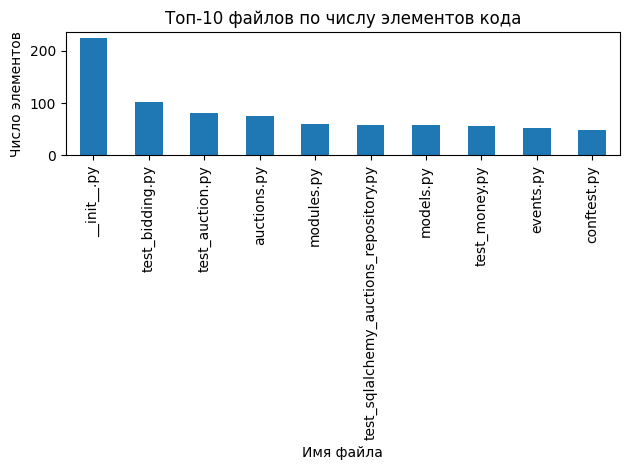

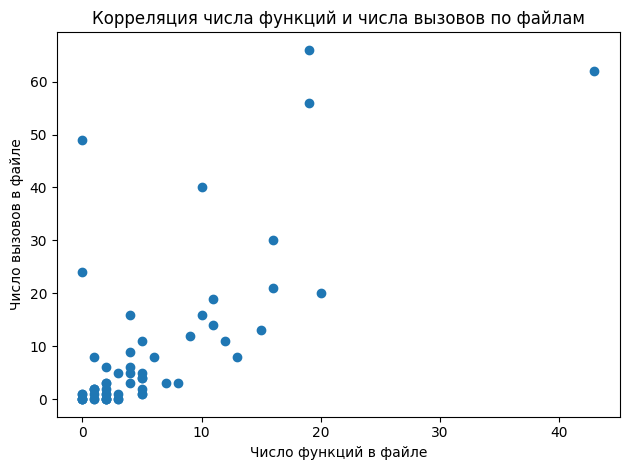

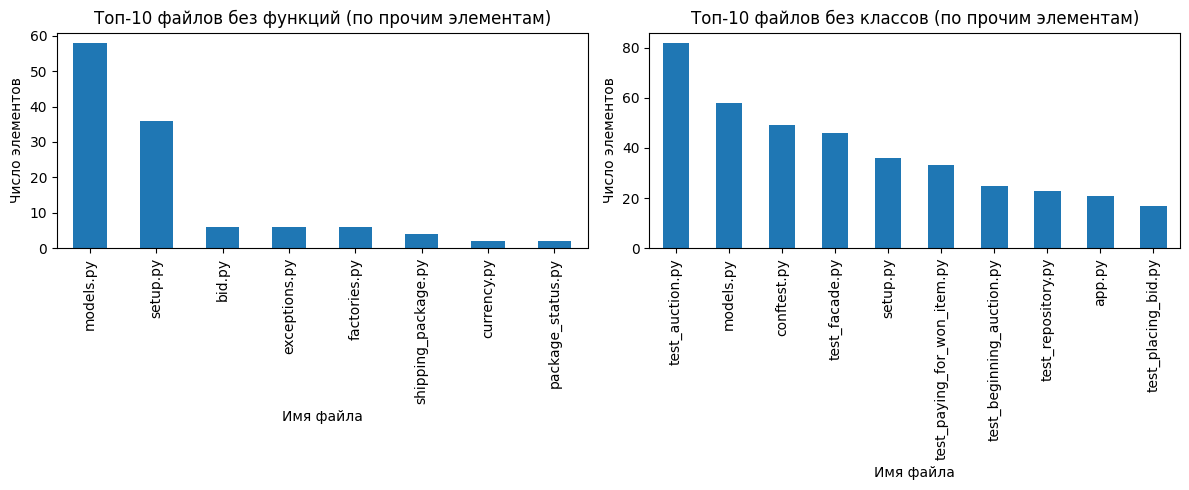

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Подготовка данных ---
# Предполагаем, что df был собран по примеру ранее:
# df = pd.read_csv('elements_dataframe.csv') 
# (или получен напрямую из предыдущего кода)

# Группировка по файлу и типу элемента
grouped = df.groupby(['filename', 'type']).size().unstack(fill_value=0)

# Добавляем суммарный столбец
grouped['total'] = grouped.sum(axis=1)

# --- 2. Топ‑10 файлов по числу элементов ---
top10 = grouped.nlargest(10, 'total')['total']

plt.figure()
top10.plot(kind='bar')
plt.title('Топ‑10 файлов по числу элементов кода')
plt.xlabel('Имя файла')
plt.ylabel('Число элементов')
plt.tight_layout()
plt.show()

# --- 3. Корреляция: функции vs. вызовы ---
plt.figure()
plt.scatter(grouped.get('function', 0), grouped.get('call', 0))
plt.title('Корреляция числа функций и числа вызовов по файлам')
plt.xlabel('Число функций в файле')
plt.ylabel('Число вызовов в файле')
plt.tight_layout()
plt.show()

no_funcs = grouped[grouped.get('function',0)==0]
no_classes = grouped[grouped.get('class',0)==0]

fig, axes = plt.subplots(1, 2, figsize=(12,5))
(no_funcs['total'].sort_values(ascending=False).head(10)
    .plot(kind='bar', ax=axes[0]))
axes[0].set_title('Топ‑10 файлов без функций (по прочим элементам)')
axes[0].set_xlabel('Имя файла')
axes[0].set_ylabel('Число элементов')

(no_classes['total'].sort_values(ascending=False).head(10)
    .plot(kind='bar', ax=axes[1]))
axes[1].set_title('Топ‑10 файлов без классов (по прочим элементам)')
axes[1].set_xlabel('Имя файла')
axes[1].set_ylabel('Число элементов')

plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import numpy as np

# Предположим, df — ваш исходный DataFrame с колонками
# ['filename', 'type', 'name', 'line'].

# 1) Собираем маппинги из определений:
defs = df[df['type'].isin(['class', 'function'])]
# name -> файл, где определено
name_to_file = defs.set_index('name')['filename'].to_dict()

# Если бы у вас были методы классов (type=='function' внутри классов),
# их можно было бы распарсить и собрать name->class. 
# Но раз у вас функции top-level, оставим пустым:
name_to_class = {}  # например: {'some_method': 'SomeClass', ...}

# 2) Функции для заполнения новых столбцов:
def map_file_from(row):
    t, n, fn = row['type'], row['name'], row['filename']
    if t in ('class', 'function'):
        # класс или функция «идёт» из своего же файла
        return fn
    if t == 'call':
        # подставляем файл, где определена вызываемая сущность
        return name_to_file.get(n, np.nan)
    # для import и др. — пока пусто
    return np.nan

def map_class_from(row):
    if row['type'] == 'call':
        return name_to_class.get(row['name'], np.nan)
    return np.nan

# 3) Применяем:
df['file_from']  = df.apply(map_file_from, axis=1)
df['class_from'] = df.apply(map_class_from, axis=1)

# Готово — смотрим результат:
df


,filename,type,name,line,file_from,class_from
0,setup.py,import,setuptools,NaN,NaN,NaN
1,setup.py,call,setup,3.0,security.py,NaN
2,setup.py,call,find_packages,6.0,NaN,NaN
3,__init__.py,class,RolesUsers,NaN,__init__.py,NaN
4,__init__.py,class,Role,NaN,__init__.py,NaN
...,...,...,...,...,...,...
1534,auctions.py,call,jsonify,34.0,NaN,NaN
1535,auctions.py,call,abort,40.0,NaN,NaN
1536,auctions.py,call,get_dto,42.0,dto.py,NaN
1537,auctions.py,call,make_response,57.0,NaN,NaN


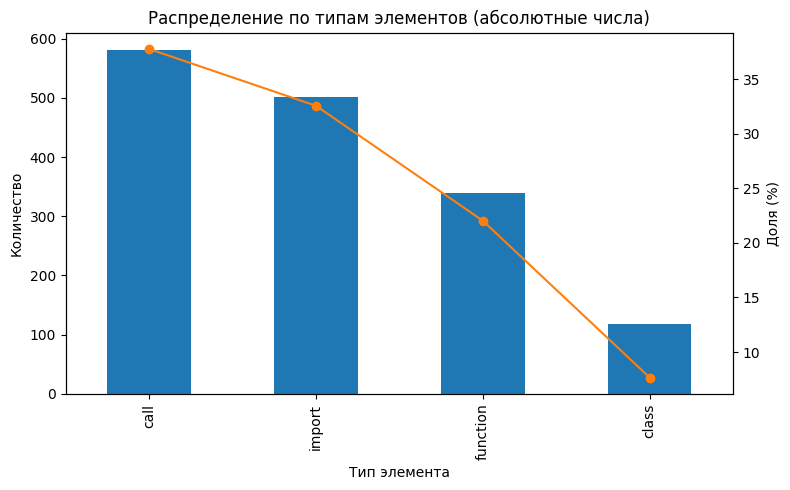

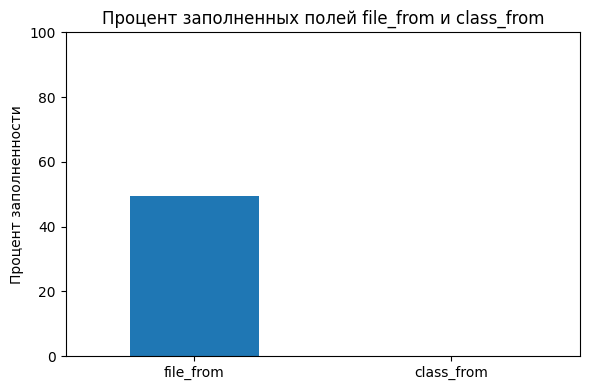

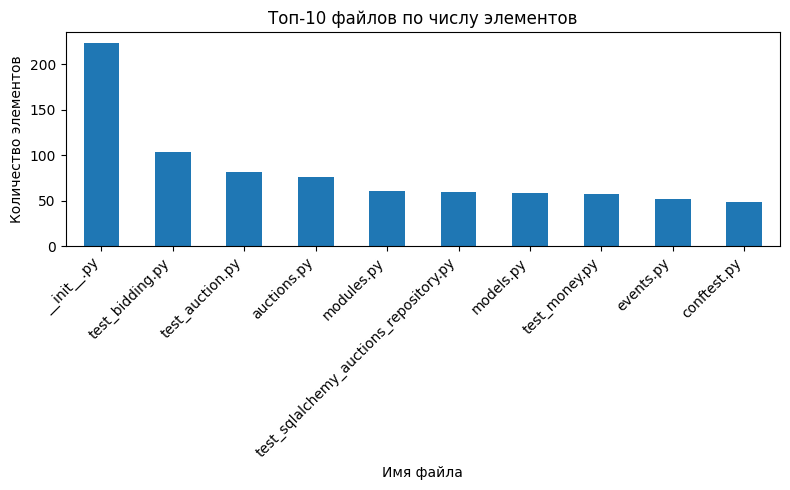

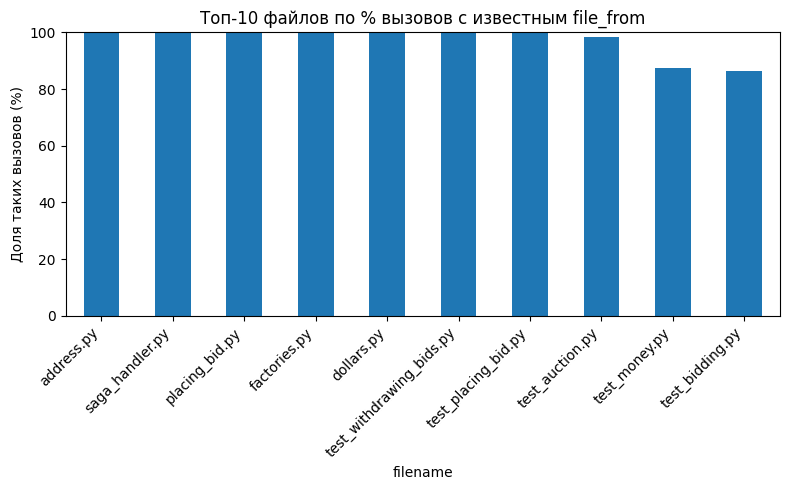

Уникальных классов в class_from: 0


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Предполагается, что df уже загружен, например:
# df = pd.read_csv('elements_with_mapping.csv')

# --- 1. Распределение по типам элементов (count & percent) ---
type_counts   = df['type'].value_counts(dropna=False)
type_percents = df['type'].value_counts(normalize=True).mul(100)

fig, ax1 = plt.subplots(figsize=(8,5))
type_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Распределение по типам элементов (абсолютные числа)')
ax1.set_xlabel('Тип элемента')
ax1.set_ylabel('Количество')

# Наложим вторую ось для процентов
ax2 = ax1.twinx()
type_percents.plot(kind='line', marker='o', ax=ax2, color='tab:orange')
ax2.set_ylabel('Доля (%)')
ax2.grid(False)

plt.tight_layout()
plt.show()


# --- 2. Заполненность file_from и class_from ---
total = len(df)
filled = pd.Series({
    'file_from':  (df['file_from'].notna().sum()/total)*100,
    'class_from': (df['class_from'].notna().sum()/total)*100
})

plt.figure(figsize=(6,4))
filled.plot(kind='bar')
plt.title('Процент заполненных полей file_from и class_from')
plt.ylim(0,100)
plt.ylabel('Процент заполненности')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# --- 3. Топ‑10 файлов по количеству элементов ---
by_file = df['filename'].value_counts().head(10)
plt.figure(figsize=(8,5))
by_file.plot(kind='bar')
plt.title('Топ‑10 файлов по числу элементов')
plt.xlabel('Имя файла')
plt.ylabel('Количество элементов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# --- 4. Топ‑10 файлов по доле call с известным file_from ---
calls            = df[df['type']=='call']
calls_with_file  = calls[calls['file_from'].notna()]
ratio = (calls_with_file['filename'].value_counts() /
         calls['filename'].value_counts()).dropna().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
ratio.mul(100).plot(kind='bar')
plt.title('Топ‑10 файлов по % вызовов с известным file_from')
plt.ylabel('Доля таких вызовов (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,100)
plt.tight_layout()
plt.show()


# --- 5. Число уникальных классов в class_from ---
unique_classes = df['class_from'].dropna().unique()
print(f"Уникальных классов в class_from: {len(unique_classes)}")


In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) Загрузка DataFrame
# df = pd.read_csv('elements_with_mapping.csv')

# Для примера:
# df = pd.DataFrame([
#     {'filename':'setup.py','type':'call','name':'setup','line':3,'file_from':'security.py','class_from':None},
#     # …
# ])

# 2) Строим ориентированный граф
G = nx.DiGraph()

# 2.1) Добавляем узлы — файлы и функции
for f in df['filename'].unique():
    G.add_node(f, kind='file')
for func in df[df['type']=='function']['name'].unique():
    G.add_node(func, kind='function')

# 2.2) Рёбра «определения» (файл → функция)
for _, r in df[df['type']=='function'].iterrows():
    G.add_edge(r['filename'], r['name'], label='defines')

# 2.3) Рёбра «вызова» (функция → file_from), только когда известен file_from
for _, r in df[(df['type']=='call') & (df['file_from'].notna())].iterrows():
    lbl = f"call @{int(r['line'])}" if not pd.isna(r['line']) else "call"
    G.add_edge(r['name'], r['file_from'], label=lbl)

# 3) Позиционирование узлов (spring layout)
pos = nx.spring_layout(G, seed=42)

# 4) Разбиваем узлы по типу для разных цветов
file_nodes     = [n for n, d in G.nodes(data=True) if d['kind']=='file']
function_nodes = [n for n, d in G.nodes(data=True) if d['kind']=='function']

# 5) Рисуем граф
plt.figure(figsize=(12, 10))

# Рёбра
nx.draw_networkx_edges(
    G, pos,
    edge_color='gray',
    arrowsize=10,
    alpha=0.5
)

# Узлы-файлы
nx.draw_networkx_nodes(
    G, pos,
    nodelist=file_nodes,
    node_shape='s',
    node_color='lightblue',
    label='File',
    node_size=800
)

# Узлы-функции
nx.draw_networkx_nodes(
    G, pos,
    nodelist=function_nodes,
    node_shape='o',
    node_color='lightgreen',
    label='Function',
    node_size=500
)

# Подписи узлов
labels = {n: n if n in file_nodes else n for n in G.nodes()}
nx.draw_networkx_labels(
    G, pos,
    labels=labels,
    font_size=8
)

# Опционально: подписи рёбер
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=6,
    label_pos=0.5
)

plt.title("Граф связей между файлами и функциями")
plt.axis('off')
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()


KeyError: 'kind'

: 